# Identify stars in images

The star catalog **hip_main.dat** consists of columns separated by | and with no header. Column 2 is the star identifier, column 6 is the magnitude, column 9 and 10 are RA and DE in degrees.

In [142]:
%matplotlib inline

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [144]:
import simulator as sim
import os

In [145]:
star_catalog = sim.StarCatalog('../data/hip_main.dat')

In [146]:
len(star_catalog.star_vectors)

117955

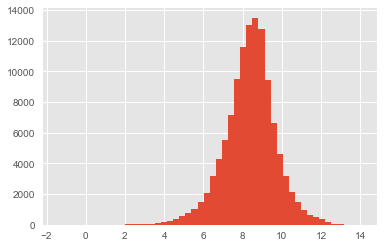

In [147]:
pd.Series(star_catalog.magnitudes).hist(bins=50)

The function *calc_md5* is used to calculate a MD5 checksum from the star catalog to detect changes of the file. In this case the features have to be recalculated.

In [148]:
from hashlib import md5

def calc_md5(file_name):
    fd = open(file_name)
    buffer = fd.read()
    hash = md5(buffer)
    fd.close()
    return hash.hexdigest()

In [149]:
signature = calc_md5('../data/hip_main.dat')

In [ ]:
def distance(v):
    return np.sqrt(np.dot(v,v))

def get_parameters(hips,relpos,relmag,distances):
    "Calculate the parameters for the nearest stars"
    param = list(hips)
    param.extend(relmag)
    for index in range(len(hips)-1):
        d1 = distances[index]
        d2 = distances[index+1]
        v1 = relpos[index]
        v2 = relpos[index+1]
        cosalpha = np.dot(v1,v2)/(d1*d2)
        if np.abs(cosalpha) > 1.0:
            cosalpha = min(1.0, cosalpha)
            cosalpha = max(-1.0, cosalpha)
        param.append(cosalpha)
        param.append(d2/d1)
    return np.array(param)

def get_columns(n):
    "Get the columns names of all features"
    cols = []
    for i in range(n):
        cols.append('hip' + str(i+1))
    for i in range(n):
        cols.append('relative_magnitude' + str(i+1))
    if n > 1:
        for i in range(n-1):
            s = str(i+1) + str(i+2)
            cols.append('normalized_angle' + s)
            cols.append('relative_distance_ratio' + s)
    return cols

def get_nearest_stars(ids, dist, n=1):
    "Get the n nearest stars"
    stars = []
    selection = np.array([True]*len(dist))
    while len(stars) < n:
        index = np.argmin(dist[selection])
        identifier = ids[selection][index]
        stars.append(identifier)
        selection[ids == identifier] = False
    return stars
    

In [ ]:

# check first if the features have been already calculated
filename = '../data/hip_feat_' + str(signature) + '.csv'
if os.path.exists(filename):
    
    features = pd.read_csv(filename, index_col = 0)

else:

    # find the N closest stars to each star in the catalog
    N = 2
    ids = star_catalog.catalog['HIP'].values
    star_catalog.catalog.index = ids
    cat = zip(ids, star_catalog.star_vectors,star_catalog.magnitudes)
    features = pd.DataFrame(index = ids, 
                            columns = get_columns(N))

    for hip, pos, mag in cat:

        # get the nearest star
        selection = ids != hip
        dist = star_catalog.star_vectors[selection] - pos
        dist2 = np.sum(dist * dist, axis=1)
        nearest_stars = get_nearest_stars(ids[selection],dist2,n=N)
        
        hips = []
        relpos = []
        relmag = []
        distances = []
        for identifier in nearest_stars:
            index = np.where(ids[selection] == identifier)[0][0]
            hips.append(identifier)
            relpos.append(dist[index])
            relmag.append(star_catalog.magnitudes[selection][index] - mag)
            distances.append(np.sqrt(dist2[index]))

        # calculate star measures
        features.ix[hip] = get_parameters(hips, relpos, relmag, distances)


    features.to_csv(filename)

In [ ]:
features['relative_distance_ratio12'][np.abs(features['relative_distance_ratio12']) < 10].hist(bins=50)